In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline


# PASO 1: IMPORTAR LA BASE DE DATOS (EN ESTE CASO LA HEMOS CREADO) Y DIVIDIRLA EN TRAIN Y TEST

In [4]:
#ESTAS FUNCIONES SON PARA DIBUJAR LA RED Y CREAR EL DATASET ( NO HAY QUE PRESTAR ATENCION)


def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)
    
def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

In [5]:
N = 5000 # VAMOS A TENER 5000 PUNTOS EN EL GRAFICO DE ABAJO, QUE VAN A SER X o Y. Las Y van a ser la clase que es 0 o 1
# las X van a ser dos dimensiones
X, y = load_planar_dataset(N, 0.2)#CARGAMOS EL DATASETE

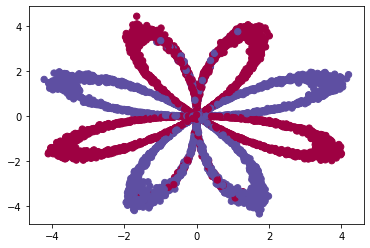

In [6]:
# Visualize the data: VISUALIZAMOS LOS DATOS.VAMOS A HACER UNA CLASIFICACION ESTE DATASET TIENE DOS CLASES LA AZUL Y LA ROJA
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);
# LOGICAMENTE SI AQUI HACEMOS UNA REGRESION LOGISTICA Y PONEMOS UNA RECTA EN CUALQUIER LADO DEL GRAFICO LA CLASIFICACION 
#VA A SER UN DESASTRE, LA FRONTERA DE DECISION ES MAS COMPLEJA.

In [7]:
# train test split # SEPARAMOS LA BASE DE DATOS EN TRAIN  Y TEST
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.2,
)

print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

# EN LA SALIDA VEREMOS QUE SON 5000 MUESTRAS DE 2 DIMENSIONES  

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


# PASO 2 CREAR UNA RED NEURONAL

In [9]:
#CREAMOS EL MODELO

model = keras.Sequential()# EN KERAS LA PRIMERA CAPA NO LA TOCAMOS, ES UNA CAPA VACIA

model.add(keras.layers.Dense(1, input_shape=(2, ), activation='sigmoid'))
# ESTA ES LA PRIMERA CAPA OCULTA COMO NO HAY MAS CAPAS TAMBIEN SERÁ LA DE SALIDA
# QUEREMOS UNA CAPA DENSA DE UNA NEURONA PORQUE ES UNA SALIDA Y ESTAMOS EN UNA REGRESION LOGISTICA 
# POR LO TANTO LA ACTIVACION ES UNA SIGMOID
# EL INPUT SHAPE ES 2 PORQUE SON 2 DIMENSIONES, SI FUERAN 3 DIMENSIONES EL INPUT SHAPE SERIA 3
# EL INPUT SHAPE SOLO SE PONE EN EL PRIMER MODEL.ADD

# YA TENEMOS EL MODELO HECHO
model.summary()
# EN EL SUMMARY VEMOS QUE TENEMOS UNA CAPA Y 3 PARAMETROS

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [10]:
# LOS MODELOS SE COMPILAN

model.compile(
    optimizer='adam',# EL ALGORITMO DE OPTIMIZACION
    loss='binary_crossentropy',# FUNCION DE PERDIDA -> ESTE ES binary_ cross.. por q es una reg log
    metrics=['accuracy']# para ver el funcionamiento del modelo, usaremos el accuracy por que es una metrica de clasificacion
)
#La regresión tiene el objetivo de predecir valores continuos (Números pues, como el 1, 2.3, 3.1416 etc…), Y la clasificación tiene la tarea de asignar una clase, es decir predecir a que clase pertenece un conjunto de datos

# ahora entrenaremos el modelo
model.fit(X_train, y_train, epochs=10,# epochs es el numero de veces que recorre el dataset para entrenar
          validation_split=0.2, batch_size=32)# cada conjunto de datos (datu multzo bat) cuantos elementos tendra

# al ejecutar veremos el loss y el accuracy en el train y en el validation(que es como la validacion cruzada)
# ya que en el train podria ser overfittin generalente

Epoch 1/10
100/100 [==============================] - 1s 4ms/step - loss: 0.9876 - accuracy: 0.5135 - val_loss: 0.9243 - val_accuracy: 0.5238
Epoch 2/10
100/100 [==============================] - 0s 1ms/step - loss: 0.9379 - accuracy: 0.5199 - val_loss: 0.8697 - val_accuracy: 0.5400
Epoch 3/10
100/100 [==============================] - 0s 1ms/step - loss: 0.8730 - accuracy: 0.5240 - val_loss: 0.8231 - val_accuracy: 0.5437
Epoch 4/10
100/100 [==============================] - 0s 1ms/step - loss: 0.8256 - accuracy: 0.5416 - val_loss: 0.7835 - val_accuracy: 0.5537
Epoch 5/10
100/100 [==============================] - 0s 1ms/step - loss: 0.7794 - accuracy: 0.5453 - val_loss: 0.7523 - val_accuracy: 0.5487
Epoch 6/10
100/100 [==============================] - 0s 1ms/step - loss: 0.7532 - accuracy: 0.5308 - val_loss: 0.7277 - val_accuracy: 0.5350
Epoch 7/10
100/100 [==============================] - 0s 1ms/step - loss: 0.7254 - accuracy: 0.5371 - val_loss: 0.7094 - val_accuracy: 0.5312
Epoch 

In [11]:
# lo evaluamos para ver el accuracy
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.6741443276405334
Test Accuracy: 0.4869999885559082


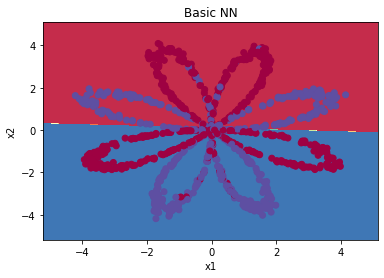

In [12]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN");
# nos pinta la prontera de decision, como es una regresion logistica logicamente nos pinta una linea

#  QUE PASA SI LE AÑADIMOS  UNA CAPA A LA RED NEURONAL?

In [13]:
model = keras.Sequential()#DECLARAMOS MODELO VACIO COMO ANTES
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))#AÑADIMOS LA PRIMERA CAPA COMO ANTES
model.add(layers.Dense(1, activation='sigmoid'))# Y AHORA AÑADIMOS OTRA CAPA (SIN INPUT SHAPE X Q SOLO SE PONE EN LA PRIMERA)
# Y SERA LA DE OUTPUT PORQUE ES LA ULTIMA
## model summary
model.summary()

#COMPILARIAMOS Y ENTRENARIAMOS, VERIAMOS EL ACCURACY Y TIRARIAMOS EL PLOT DECISSION Y VERIAMOS QUE HA MEJORADO

#VEMOS QUE EL MODELO HA MEJORADO AL METER UNA CAPA OCULTA, HA ENCONTRADO NO LINEALIDADES


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


#QUE PASARIA SI EN LA PRIMERA CAPA OCULTA EN VEZ DE UNA SIGMOID PONEMOS UNA ACTIVACION LINEAL?

In [14]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='linear'))# poner linear es igual que no poner nada
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

#COMPILARIAMOS Y ENTRENARIAMOS, VERIAMOS EL ACCURACY Y TIRARIAMOS EL PLOT DECISSION 
# vemos que el resultado es malo, o.40ypico. nunca usaremos activacion lineal en las capas intermedias en ningun modelo.
#NO FUNCIONAN 


# QUE PASARIA SI AÑADIMOS MAS NEURONAS A LA PRIMERA CAPA OCULTA (EN VEZ DE 3 EN LAYERS DENSE 5 POR EJEMPLO)

In [15]:
model = keras.Sequential()

## The first layer need to have the input_shape
## set the number of neurons
model.add(layers.Dense(5, input_shape=(2,), activation='sigmoid'))
# EN EL DIBUJO TENEMOS 5 ASI Q PONDRMOS 5 PA CREAR LA MISMA RED

# output layer
model.add(layers.Dense(1, activation='sigmoid'))
#COMPILARIAMOS Y ENTRENARIAMOS, VERIAMOS EL ACCURACY Y TIRARIAMOS EL PLOT DECISSION 
#HA MEJPRADO UN POCO, AUNQUE ESTO DE LAS NEURONAS ES UN POCO A BOLEO

# QUE PASARIA SI AÑADIMOS OTRA CAPA?

In [17]:
model = keras.Sequential()# CAPA INICIAL

model.add(layers.Dense(3, input_shape=(2,), activation='linear'))# poner linear es igual que no poner nada#PRIMERA OCULTA

model.add(layers.Dense(1, activation='sigmoid'))                                                                #SEGUNDA OCULTA

# output layer
model.add(layers.Dense(1, activation='sigmoid'))# CAPA DE SALIDA O OUTPUT
#COMPILARIAMOS Y ENTRENARIAMOS, VERIAMOS EL ACCURACY Y TIRARIAMOS EL PLOT DECISSION 
# GENERALMENTE MEJORA PERO A VECES NO.

# AHORA PROBAREMOS UNA NUEVA FUNCION DE ACTIVACION LLAMADA tanh en vez de sigmoid o linear (para la logistica sigmoid, para la lineal linear o nada y tanh para)

In [ ]:
# el cambio solo lo realizaremos en las capas ocultas ya que la final siempre tiene que ser una sigmoid porque es una clasificacion binaria. hay otra que se llama relu tambien

In [ ]:
model = keras.Sequential()# CAPA INICIAL

model.add(layers.Dense(3, input_shape=(2,), activation='tanh'))# poner linear es igual que no poner nada#PRIMERA OCULTA

# output layer
model.add(layers.Dense(1, activation='sigmoid'))# CAPA DE SALIDA O OUTPUT

#COMPILARIAMOS Y ENTRENARIAMOS, VERIAMOS EL ACCURACY Y TIRARIAMOS EL PLOT DECISSION 
# HAY VECES QUE MEJORARA Y OTRAS QUE NO

# CASO PRACTICO NUMERO 1: CONSIGUE UN 80% DE ACCURACY CON ESTA BASE DE DATOS.

In [21]:

N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise=.18)

In [22]:
# YA TENEMOS LA BASE DE DATOS, AHORA REALIZAREMOS EL TRAIN/TEST SPLIT
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


Epoch 1/35
47/47 [==============================] - 1s 4ms/step - loss: 0.7662 - accuracy: 0.5136 - val_loss: 0.7739 - val_accuracy: 0.4680
Epoch 2/35
47/47 [==============================] - 0s 2ms/step - loss: 0.7400 - accuracy: 0.5116 - val_loss: 0.7468 - val_accuracy: 0.4680
Epoch 3/35
47/47 [==============================] - 0s 2ms/step - loss: 0.7186 - accuracy: 0.5156 - val_loss: 0.7265 - val_accuracy: 0.4680
Epoch 4/35
47/47 [==============================] - 0s 2ms/step - loss: 0.7028 - accuracy: 0.5201 - val_loss: 0.7110 - val_accuracy: 0.4680
Epoch 5/35
47/47 [==============================] - 0s 2ms/step - loss: 0.6975 - accuracy: 0.5009 - val_loss: 0.6967 - val_accuracy: 0.4680
Epoch 6/35
47/47 [==============================] - 0s 2ms/step - loss: 0.6805 - accuracy: 0.5194 - val_loss: 0.6843 - val_accuracy: 0.4680
Epoch 7/35
47/47 [==============================] - 0s 2ms/step - loss: 0.6736 - accuracy: 0.5009 - val_loss: 0.6720 - val_accuracy: 0.4680
Epoch 8/35
47/47 [==

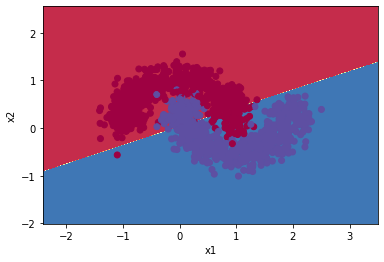

In [24]:
#REALIZAREMOS EL MODELO
model = keras.Sequential()#definimos el modelo vacio
model.add(layers.Dense(5, input_shape=(2,), activation='sigmoid'))#OCULTA 1 (SIEMPRE LLEVA EL INPUT SHAPE)
model.add(layers.Dense(3, activation='sigmoid'))#OCULTA 2
model.add(layers.Dense(1, activation='sigmoid'))#OUTPUT

## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
# EL ACCURACY DA MAS QUE 0.85!!

# HASTA AHORA TODO LO HEMOS HECHO USANDO EL MODEL.ADD QUE ES EL METODO SECUENCIAL. AHORA HAREMOS LO MISMO PERO CON OTRO METODO QUE ES EL METODO FUNCIONAL QUE SE SUELE UTILIZAR PARA MODELOS MAS COMPLEJOS


X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


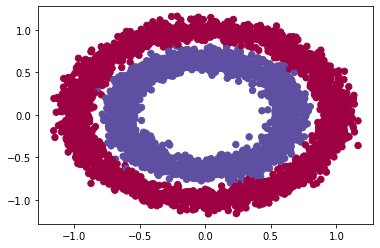

In [25]:
# A CONTINUACION VEREMOS LA COMPOSICION DE UN MODELO REALIZADO CON EL METODO FUNCIONAL
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=.065) # CREAMOS LA BASE DE DATOS

# VISUALIZAMOS LA BASE DE DATOS
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);
# train test split
from sklearn.model_selection import train_test_split
#DIVIDIMOS EN TRAIN Y TEST
(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

Model: "example_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
layer_1 (Dense)              (None, 16)                48        
_________________________________________________________________
layer_2 (Dense)              (None, 16)                272       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 17        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
47/47 [==============================] - 1s 5ms/step - loss: 0.7156 - accuracy: 0.5023 - val_loss: 0.6927 - val_accuracy: 0.5133
Epoch 2/35
47/47 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.5074 - val_loss: 0.6

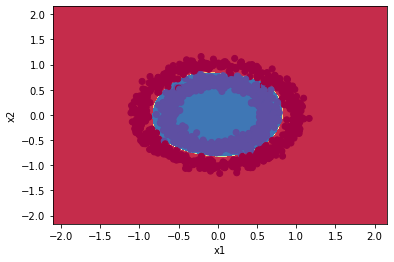

In [28]:
# CREAREMOS EL MODELO: no se pporque los activation tanh me dan tan buen resultado

inputs = keras.Input(shape=(2, ), name='input_layer')#aqui son 8
l_1 = layers.Dense(16, activation='tanh', name='layer_1')(inputs)
l_2 = layers.Dense(16, activation='tanh', name='layer_2')(l_1)#llama a la anterior
outputs = layers.Dense(1,activation ='sigmoid', name='output_layer')(l_2)# la salida llama a la anterior

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

model.summary()



## COMPILAMOS Y ENTRENAMOS COMO EN EL SECUENCIAL
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

#VISUALIZAMOS LOS RESULTADOS COMO EN EL SECUENCIAL
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)